In [3]:
import pandas as pd
import numpy as np
import os

# Load and Merge Data
- want to see cycle data

In [11]:
fp = os.path.join('..', 'data_out', 'Symptoms_clean.csv')
symptoms =pd. read_csv(fp)
#set zeroes as nans
symptoms.replace(0, np.NaN, inplace=True)
symptoms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13512 entries, 0 to 13511
Data columns (total 14 columns):
symptom_id    13512 non-null int64
user_id       13512 non-null int64
acne          4230 non-null float64
backache      5027 non-null float64
bloating      5278 non-null float64
cramp         6943 non-null float64
diarrhea      2233 non-null float64
dizzy         2170 non-null float64
headache      4402 non-null float64
mood          5177 non-null float64
nausea        2194 non-null float64
sore          4090 non-null float64
date          13512 non-null object
date_fix      13511 non-null object
dtypes: float64(10), int64(2), object(2)
memory usage: 1.4+ MB


#### Agg Symptoms

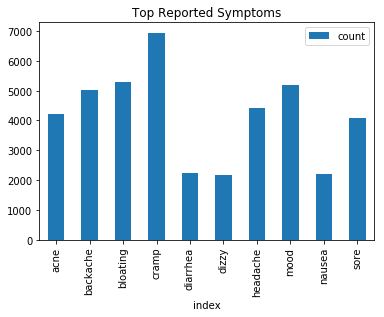

In [26]:
categories = ['acne', 'backache', 'bloating', 'cramp',
       'diarrhea', 'dizzy', 'headache', 'mood', 'nausea', 'sore']
agg_symptoms = symptoms[categories].agg(['mean', 'count']).T
agg_symptoms.sort_values('count', ascending=False)
agg_symptoms.reset_index().plot.bar(x='index', y='count', title='Top Reported Symptoms')

#### Agg to the User Level

In [30]:
users_agg_symptoms = symptoms.groupby(['user_id'], as_index=False).mean()
users_agg_symptoms.sample(5)

,user_id,symptom_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore
538,1288,1076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3002,5440,9247.000000,NaN,55.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN
1883,3555,4718.000000,74.0,75.0,71.0,70.0,NaN,NaN,NaN,33.0,NaN,44.0
3724,6668,12969.333333,28.0,NaN,43.0,42.4,25.5,20.25,NaN,20.0,21.5,NaN
1298,2606,3107.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Cycle Data

In [57]:
fp = os.path.join('..', 'data_out', 'Clean_periods_clean.csv')
periods = pd.read_csv(fp, parse_dates=['start_date_fix', 'end_date_fix'])
periods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31964 entries, 0 to 31963
Data columns (total 7 columns):
period_id         31964 non-null int64
start_date        31964 non-null object
end_date          31964 non-null object
user_id           31964 non-null int64
start_date_fix    31964 non-null datetime64[ns]
end_date_fix      31964 non-null datetime64[ns]
length            31964 non-null object
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 1.7+ MB


In [58]:
print('predrop:', periods.shape[0])
periods_multi_respos = periods.groupby('user_id').filter(lambda x: x.shape[0] > 1).copy()
print('postdrop:', periods_multi_respos.shape[0])

predrop: 31964
postdrop: 28549


In [65]:
#sort
periods_multi_respos.sort_values(['user_id', 'start_date_fix'], inplace=True)
#roll column
periods_multi_respos['previous_start_date'] = periods_multi_respos.start_date_fix.shift(1)
#calc difference
periods_multi_respos['cycle_length'] = periods_multi_respos['start_date_fix'] - periods_multi_respos['previous_start_date']
#set non repeated user it 
cumcount = periods_multi_respos.groupby('user_id').cumcount()
periods_multi_respos.loc[cumcount==0, 'cycle_length'] = np.NaN
#drop missing data
periods_multi_respos.dropna(subset=['cycle_length'], inplace=True)
#check cycle_length stats
print('stats pre drop:', periods_multi_respos.cycle_length.describe(), sep='\n')
#drop any cycle ove 60 days

stats pre drop:
count                      19847
mean     36 days 03:50:26.089585
std      32 days 15:41:37.143020
min              0 days 00:00:00
25%             26 days 00:00:00
50%             29 days 00:00:00
75%             34 days 00:00:00
max            947 days 00:00:00
Name: cycle_length, dtype: object


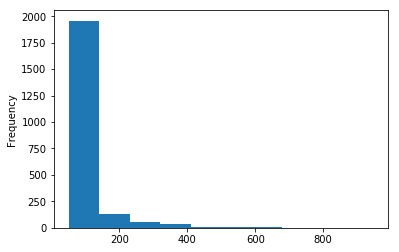

In [71]:
days = periods_multi_respos.cycle_length.dt.days
days = days[(days > 50 ]
days.plot.hist()